<a href="https://colab.research.google.com/github/034adarsh/Stock-Price-Prediction-Using-LSTM/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the required libraries

---



In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import ipywidgets as widgets
from IPython.display import display

In [28]:
window_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=200,
    step=10,
    description='Window Size:',
    continuous_update=False
)

train_split_slider = widgets.FloatSlider(
    value=0.8,
    min=0.5,
    max=0.9,
    step=0.05,
    description='Train Split:',
    continuous_update=False
)

display(window_slider, train_split_slider)

IntSlider(value=100, continuous_update=False, description='Window Size:', max=200, min=10, step=10)

FloatSlider(value=0.8, continuous_update=False, description='Train Split:', max=0.9, min=0.5, step=0.05)

# Define start day to fetch the dataset from the yahoo finance library

---



In [29]:
df = pd.read_csv("StockHistoricalData/TSLA.csv")
print(df.head())


           Date    Open    High     Low   Close  Adj Close       Volume
0  Nov 26, 2025  423.95  426.94  416.89  426.58     426.58   63,299,400
1  Nov 25, 2025  414.42  420.48  405.95  419.40     419.40   71,915,600
2  Nov 24, 2025  402.17  421.72  401.09  417.78     417.78   96,806,400
3  Nov 21, 2025  402.32  402.80  383.76  391.09     391.09  100,460,600
4  Nov 20, 2025  414.63  428.94  394.74  395.23     395.23  113,548,800


In [30]:
df = df.drop(['Date','Adj Close'], axis = 1)

first = df.iloc[:1]
reversed_rest = df.iloc[1:][::-1].reset_index(drop=True)
df = pd.concat([first, reversed_rest], ignore_index=True)

df['Volume'] = (
    df['Volume']
        .astype(str)
        .str.replace(',', '', regex=False)
)

df = df[df['Volume'] != 'nan']
df['Volume'] = df['Volume'].astype(int)

df.head()

,Open,High,Low,Close,Volume
0,423.95,426.94,416.89,426.58,63299400
1,193.72,199.59,192.82,195.25,112683300
2,200.74,202.60,184.84,189.20,189009300
3,199.2,199.28,190.68,194.92,120310500
4,185.48,190.51,180.40,189.61,143327100


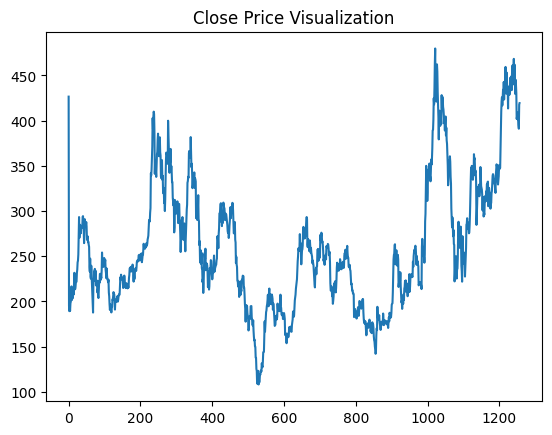

In [31]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

# Plotting moving averages of 100 day

---



Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

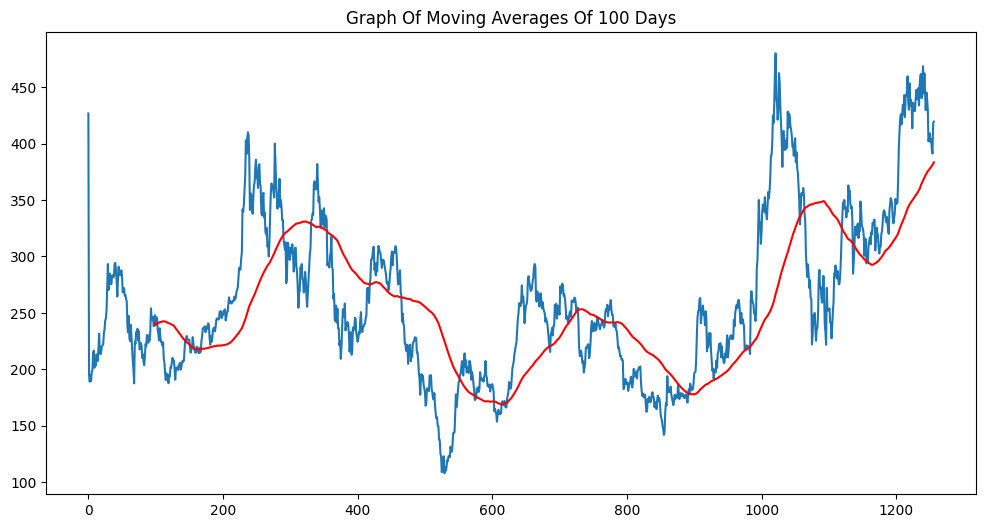

In [46]:
ma100 = df.Close.rolling(100).mean()
ma100

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [33]:
split_index = int(len(df) * 0.8)
train = df[:split_index]
test = df[split_index:]

In [34]:
train.head

<bound method NDFrame.head of         Open    High     Low   Close     Volume
0     423.95  426.94  416.89  426.58   63299400
1     193.72  199.59  192.82  195.25  112683300
2     200.74  202.60  184.84  189.20  189009300
3      199.2  199.28  190.68  194.92  120310500
4     185.48  190.51  180.40  189.61  143327100
...      ...     ...     ...     ...        ...
1000  310.57  324.68  309.22  320.72  114440300
1001  340.73  348.55  330.01  338.74  126085600
1002  335.76  347.38  332.75  346.00   88852500
1003     345  346.60  334.30  342.03   66340700
1004  343.81  347.99  335.28  339.64   58011700

[1004 rows x 5 columns]>

In [35]:
test.head

<bound method NDFrame.head of         Open    High     Low   Close     Volume
1005  341.09  361.53  337.70  352.56   89140700
1006  360.14  361.93  338.20  338.59   95890900
1007     341  346.96  335.66  338.23   62295900
1008   341.8  342.55  326.59  332.89   57896400
1009  336.08  345.45  334.65  345.16   37167600
...      ...     ...     ...     ...        ...
1252  406.18  411.78  398.50  403.99   72047700
1253  414.63  428.94  394.74  395.23  113548800
1254  402.32  402.80  383.76  391.09  100460600
1255  402.17  421.72  401.09  417.78   96806400
1256  414.42  420.48  405.95  419.40   71915600

[252 rows x 5 columns]>

# Using MinMax scaler for normalization of the dataset

---



In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

train_close = train.iloc[:, 3:4].values
test_close = test.iloc[:, 3:4].values

train_close

array([[426.58],
       [195.25],
       [189.2 ],
       ...,
       [346.  ],
       [342.03],
       [339.64]], shape=(1004, 1))

In [37]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[1.        ],
       [0.27364356],
       [0.25464707],
       ...,
       [0.74698568],
       [0.73452022],
       [0.72701583]], shape=(1004, 1))

In [38]:
data_testing_array = scaler.transform(test_close)
data_testing_array

array([[0.76758352],
       [0.72371891],
       [0.72258855],
       [0.7058214 ],
       [0.74434815],
       [0.78180733],
       [0.76400402],
       [0.78444486],
       [0.82074228],
       [0.88269279],
       [0.88448254],
       [0.91964959],
       [0.99431675],
       [0.97337352],
       [1.03030018],
       [1.11441849],
       [1.16729465],
       [1.04254584],
       [1.03011178],
       [0.98266767],
       [1.01262246],
       [1.11209495],
       [1.08650465],
       [1.01595077],
       [0.97120698],
       [0.92859834],
       [0.85148204],
       [0.94932178],
       [0.95123713],
       [0.89883195],
       [0.9006531 ],
       [0.90002512],
       [0.92693419],
       [0.90511178],
       [1.00514946],
       [0.95993469],
       [0.99974881],
       [0.99211881],
       [0.96398518],
       [0.95541321],
       [0.93720171],
       [0.90759231],
       [0.91054383],
       [0.882316  ],
       [0.91742025],
       [0.93098468],
       [0.86529766],
       [0.892

In [39]:
x_train = []
y_train = []
window_size = 100

for i in range(window_size, data_training_array.shape[0]):
    x_train.append(data_training_array[i-window_size:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [40]:
x_train

array([[[1.        ],
        [0.27364356],
        [0.25464707],
        ...,
        [0.40853429],
        [0.41308716],
        [0.43939965]],

       [[0.27364356],
        [0.25464707],
        [0.27260739],
        ...,
        [0.41308716],
        [0.43939965],
        [0.41384074]],

       [[0.25464707],
        [0.27260739],
        [0.25593444],
        ...,
        [0.43939965],
        [0.41384074],
        [0.42398267]],

       ...,

       [[0.28190153],
        [0.31951771],
        [0.38671188],
        ...,
        [0.63765386],
        [0.66760864],
        [0.7241899 ]],

       [[0.31951771],
        [0.38671188],
        [0.43421879],
        ...,
        [0.66760864],
        [0.7241899 ],
        [0.74698568]],

       [[0.38671188],
        [0.43421879],
        [0.45032655],
        ...,
        [0.7241899 ],
        [0.74698568],
        [0.73452022]]], shape=(904, 100, 1))

In [41]:
x_test = []
y_test = []

for i in range(window_size, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i-window_size:i])
    y_test.append(data_testing_array[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [42]:
x_test.shape

(152, 100, 1)

# Training the ML model (LSTM)

---



In [49]:
import ipywidgets as widgets
from IPython.display import display
import tensorflow as tf

class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs, progress_bar, output_area):
        super().__init__()
        self.epochs = epochs
        self.progress_bar = progress_bar
        self.output_area = output_area

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.value = epoch + 1
        
        with self.output_area:
            self.output_area.clear_output(wait=True)
            print(f"Epoch {epoch+1}/{self.epochs}")
            print(f"Loss: {logs['loss']:.6f}")

In [50]:
def train_model(window_size, train_split, epochs):

    # UI elements
    progress_bar = widgets.IntProgress(
        value=0,
        min=0,
        max=epochs,
        description='Training:',
        bar_style='info'
    )

    training_output = widgets.Output()
    plot_output = widgets.Output()

    display(progress_bar)
    display(training_output)
    display(plot_output)

    split_index = int(len(df) * train_split)
    train = df[:split_index]
    test = df[split_index:]

    scaler = MinMaxScaler(feature_range=(0,1))

    train_close = train.iloc[:, 3:4].values
    test_close = test.iloc[:, 3:4].values

    data_training_array = scaler.fit_transform(train_close)
    data_testing_array = scaler.transform(test_close)

    # Create sequences
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i-window_size:i])
        y_train.append(data_training_array[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_test, y_test = [], []
    for i in range(window_size, len(data_testing_array)):
        x_test.append(data_testing_array[i-window_size:i])
        y_test.append(data_testing_array[i, 0])
    x_test, y_test = np.array(x_test), np.array(y_test)

    # Build model
    model = Sequential([
        tf.keras.Input(shape=(x_train.shape[1], 1)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    progress_callback = TrainingProgressCallback(
        epochs, progress_bar, training_output
    )

    model.fit(
        x_train,
        y_train,
        epochs=epochs,
        verbose=0,
        callbacks=[progress_callback]
    )

    progress_bar.bar_style = 'success'
   
    model.save("keras_model.h5")
    print("Model saved as keras_model.h5")

    # Predictions
    y_pred = model.predict(x_test, verbose=0)

    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Show plot inside controlled output area
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.figure(figsize=(10,5))
        
        plt.plot(y_test, label="Actual")
        plt.plot(y_pred, label="LSTM")
        
        plt.xlabel("Day")
        plt.ylabel("Price (USD)")
        plt.title("Stock Price Prediction")
        
        plt.legend()
        plt.show()

In [51]:
window_slider = widgets.IntSlider(
    min=10, max=200, step=10, value=100,
    description="Window Size:"
)

train_split_slider = widgets.FloatSlider(
    min=0.5, max=0.9, step=0.05, value=0.8,
    description="Train Split:"
)

epoch_slider = widgets.IntSlider(
    min=5, max=50, step=5, value=20,
    description="Epochs:"
)

run_button = widgets.Button(
    description="Train Model",
    button_style='success'
)

display(window_slider, train_split_slider, epoch_slider, run_button)

def on_button_click(b):
    train_model(
        window_slider.value,
        train_split_slider.value,
        epoch_slider.value
    )

run_button.on_click(on_button_click)

IntSlider(value=100, description='Window Size:', max=200, min=10, step=10)

FloatSlider(value=0.8, description='Train Split:', max=0.9, min=0.5, step=0.05)

IntSlider(value=20, description='Epochs:', max=50, min=5, step=5)

Button(button_style='success', description='Train Model', style=ButtonStyle())

IntProgress(value=0, bar_style='info', description='Training:', max=20)

Output()

Output()

Model saved as keras_model.h5


Loading saved model...


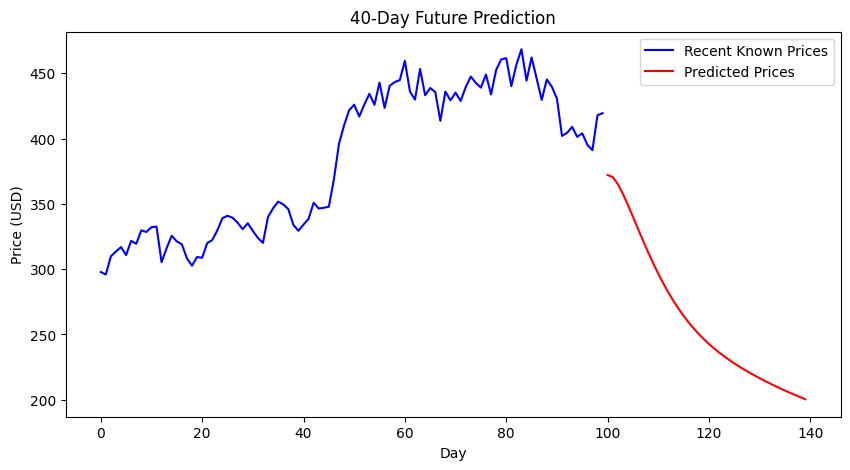

In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

days_ahead = int(input("Enter number of days to predict ahead: "))
model_path = "keras_model.h5"

if not os.path.exists(model_path):
    print("ERROR: keras_model.h5 not found. Please train a model first.")
else:
    
    print("Loading saved model...")
    model = load_model(model_path)

    window_size = 100

    close_prices = df[['Close']].values
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(close_prices)
    last_window = scaled_data[-window_size:]
    
    predictions = []
    current_window = last_window.copy()

    for _ in range(days_ahead):
        input_data = current_window.reshape(1, window_size, 1)
        next_pred = model.predict(input_data, verbose=0)
        
        predictions.append(next_pred[0,0])

        current_window = np.vstack((current_window[1:], next_pred))

    predictions = np.array(predictions).reshape(-1,1)
    predicted_prices = scaler.inverse_transform(predictions).flatten()


    previous_days = 100

    if previous_days > 0:
        recent_known = close_prices[-previous_days:].flatten()
    else:
        recent_known = np.array([])

    plt.figure(figsize=(10,5))

    x_known = range(len(recent_known))
    x_pred = range(len(recent_known), len(recent_known) + len(predicted_prices))

    if previous_days > 0:
        plt.plot(x_known, recent_known, color='blue', label="Recent Known Prices")

    plt.plot(x_pred, predicted_prices, color='red', label="Predicted Prices")

    plt.xlabel("Day")
    plt.ylabel("Price (USD)")
    plt.title(f"{days_ahead}-Day Future Prediction")
    plt.legend()
    plt.show()